In [2]:
import matplotlib
import numpy as np
import pygimli as pg
import matplotlib.pyplot as plt

from pygimli.viewer.mpl import drawStreams

Going to attempt to plot potential distribution for multiple layers according to the tutorial here: https://www.pygimli.org/_examples_auto/3_dc_and_ip/plot_04_ert_2_5d_potential.html#sphx-glr-examples-auto-3-dc-and-ip-plot-04-ert-2-5d-potential-py

In [3]:
"""
One layer model exactly from the tutorial
"""

# Mixed Boundary Condition rules. Check if this needs to be changed for multiple layers.

def mixedBC(boundary, userData):
    """
    boundary:
    userData: dictionary with keys 'sourcePos' for RV vector of the current source, 
    'k' for the wavenumber for fourier transform, 's' for the conductivity distribution.
    """
    if boundary.norm()[1] == 1.0: # if at surface
        return 0

    sourcePos = userData['sourcePos']
    k = userData['k']
    sigma = userData['s']
    r1 = boundary.center() - sourcePos # distance to boundary

    # Mirror on surface at depth=0
    r2 = boundary.center() - pg.Pos(1.0, -1.0) * sourcePos
    r1A = r1.abs()
    r2A = r2.abs()

    n = boundary.norm() # marker for boundary
    if r1A > 1e-12 and r2A > 1e-12: # if not at the source
        alpha = sigma * k * ((r1.dot(n)) / r1A * pg.math.besselK1(r1A * k) +
                            (r2.dot(n)) / r2A * pg.math.besselK1(r2A * k)) / \
            (pg.math.besselK0(r1A * k) + pg.math.besselK0(r2A * k)) # if boundary is in the subsurface, apply this condition

        return alpha

        # Note, the above is the same like:
        beta = 1.0
        return [alpha, beta, 0.0]

    else:
        return 0.0
    
def RobinBC(boundary, userData):
    """
    boundary:
    userData: dictionary with keys 'sourcePos' for RV vector of the current source, 
    'k' for the wavenumber for fourier transform, 's' for the conductivity distribution.
    """
    if boundary.norm()[1] == 1.0: # if at surface
        return 0

    sourcePos = userData['sourcePos']
    k = userData['k']
    sigma = userData['s']
    r1 = boundary.center() - sourcePos # distance to boundary

    # Mirror on surface at depth=0
    r2 = boundary.center() - pg.Pos(1.0, -1.0) * sourcePos
    r1A = r1.abs()
    r2A = r2.abs()

    n = boundary.norm() # marker for boundary
    if r1A > 1e-12 and r2A > 1e-12: # if not at the source
#         alpha = sigma * k * ((r1.dot(n)) / r1A * pg.math.besselK1(r1A * k) +
#                             (r2.dot(n)) / r2A * pg.math.besselK1(r2A * k)) / \
#             (pg.math.besselK0(r1A * k) + pg.math.besselK0(r2A * k)) # if boundary is in the subsurface, apply this condition
        
        alpha = ((r2A**3)*(r1.dot(n)) + (r1A**3)*(r2.dot(n)))/((r2A**3)*(r1A**3)*(r1A + r2A))

        return alpha

        # Note, the above is the same like:
        beta = 1.0
        return [alpha, beta, 0.0]

    else:
        return 0.0
    

def rhsPointSource(mesh, source):
    """
    Delta function for the current source, taken by setting an empty vector 
    at the injection source.
    """
    rhs = pg.Vector(mesh.nodeCount())

    cell = mesh.findCell(source)
    rhs.setVal(cell.N(cell.shape().rst(source)), cell.ids())
    return rhs

Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.042
Solving time:  0.036
Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.038
Solving time:  0.016


Text(0.5, 1.0, 'One Layer Potential Distribution (1 ohm*m Conductivity) Mixed BC')

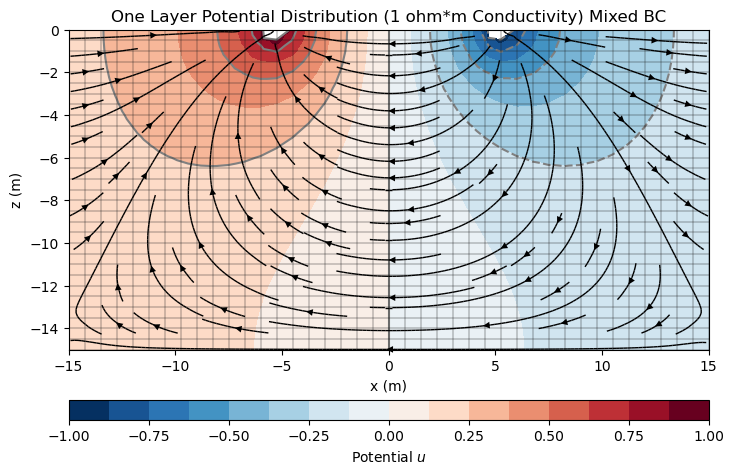

In [4]:
# Make the mesh and current injection sources.

mesh = pg.createGrid(x=np.linspace(-15.0, 15.0, 41),
                     y=np.linspace(-15.0,  0, 31))
mesh = mesh.createP2()

sourcePosA = [-5.25, 0]
sourcePosB = [+5.25, 0]

k = 1e-2
sigma = 1.0
bc={'Robin': {'1,2,3': mixedBC}}
u = pg.solve(mesh, a=sigma, b=-sigma * k*k,
             rhs=rhsPointSource(mesh, sourcePosA),
             bc=bc, userData={'sourcePos': sourcePosA, 'k': k, 's':sigma},
             verbose=True)

u -= pg.solve(mesh, a=sigma, b=-sigma * k*k,
              rhs=rhsPointSource(mesh, sourcePosB),
              bc=bc, userData={'sourcePos': sourcePosB, 'k': k, 's':sigma},
              verbose=True)


# The solution is shown by calling
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

axe = pg.show(mesh, data=u, ax=ax, cMap="RdBu_r", cMin=-1, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

# Additionally to the image of the potential we want to see the current flow.
# The current flows along the gradient of our solution and can be plotted as
# stream lines. By default, the drawStreams method draws one segment of a
# stream line per cell of the mesh. This can be a little confusing for dense
# meshes so we can give a second (coarse) mesh as a new cell base to draw the
# streams. If `drawStreams` gets scalar data, the gradients will be calculated.
gridCoarse = pg.createGrid(x=np.linspace(-15.0, 15.0, 20),
                           y=np.linspace(-15.0, 0, 20))
drawStreams(axe, mesh, u, coarseMesh=gridCoarse, color='Black')

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("One Layer Potential Distribution (1 ohm*m Conductivity) Mixed BC")

Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.029
Solving time:  0.026
Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.043
Solving time:  0.028


Text(0.5, 1.0, 'One Layer Potential Distribution (1 ohm*m Conductivity) Robin BC')

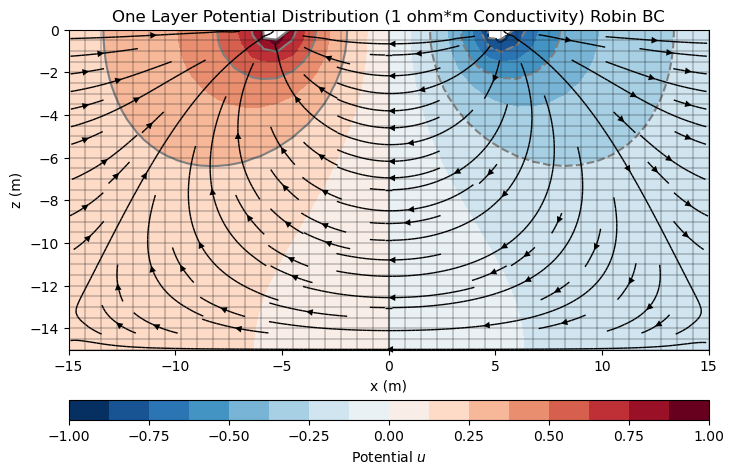

In [5]:
# Make the mesh and current injection sources.

sourcePosA = [-5.25, 0]
sourcePosB = [+5.25, 0]

k = 1e-2
sigma = 1.0
bc={'Robin': {'1,2,3': RobinBC}}
u2 = pg.solve(mesh, a=sigma, b=-sigma * k*k,
             rhs=rhsPointSource(mesh, sourcePosA),
             bc=bc, userData={'sourcePos': sourcePosA, 'k': k, 's':sigma},
             verbose=True)

u2 -= pg.solve(mesh, a=sigma, b=-sigma * k*k,
              rhs=rhsPointSource(mesh, sourcePosB),
              bc=bc, userData={'sourcePos': sourcePosB, 'k': k, 's':sigma},
              verbose=True)


# The solution is shown by calling
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

axe = pg.show(mesh, data=u, ax=ax, cMap="RdBu_r", cMin=-1, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

# Additionally to the image of the potential we want to see the current flow.
# The current flows along the gradient of our solution and can be plotted as
# stream lines. By default, the drawStreams method draws one segment of a
# stream line per cell of the mesh. This can be a little confusing for dense
# meshes so we can give a second (coarse) mesh as a new cell base to draw the
# streams. If `drawStreams` gets scalar data, the gradients will be calculated.
gridCoarse = pg.createGrid(x=np.linspace(-15.0, 15.0, 20),
                           y=np.linspace(-15.0, 0, 20))
drawStreams(axe, mesh, u, coarseMesh=gridCoarse, color='Black')

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("One Layer Potential Distribution (1 ohm*m Conductivity) Robin BC")

Text(0.5, 1.0, 'Difference Between Analytical & Neumman/Dirichlet Solutions (1-Layer, 1 ohm*m)')

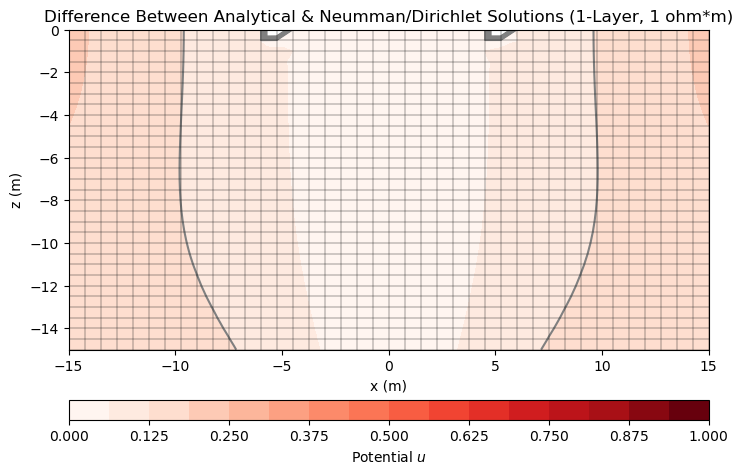

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
axe = pg.show(mesh, data=np.abs(uAna-u3), ax=ax, cMap="Reds", cMin=0, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Difference Between Analytical & Neumman/Dirichlet Solutions (1-Layer, 1 ohm*m)")

31/01/23 - 10:26:33 - pyGIMLi - INFO - Fixing pure Neumann boundary condition by forcing: intDomain(u, mesh) = 0
31/01/23 - 10:26:33 - pyGIMLi - WARNING - BlockMatrix add (transpose==True) ... Move me to core


Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.031


31/01/23 - 10:26:34 - pyGIMLi - INFO - Fixing pure Neumann boundary condition by forcing: intDomain(u, mesh) = 0
31/01/23 - 10:26:34 - pyGIMLi - WARNING - BlockMatrix add (transpose==True) ... Move me to core


Solving time:  0.313
Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.033
Solving time:  0.327


Text(0.5, 1.0, 'One Layer Potential Distribution (1 ohm*m Conductivity) \n Neummann/Dirichlet BC')

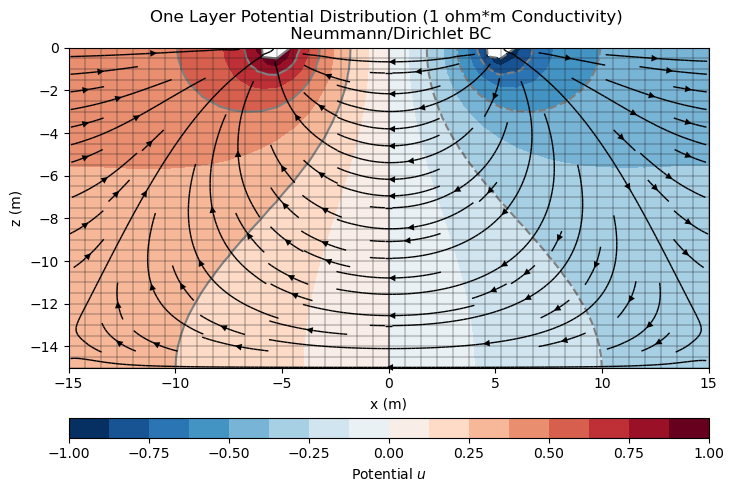

In [7]:
# Make the mesh and current injection sources.

sourcePosA = [-5.25, 0]
sourcePosB = [+5.25, 0]

k = 1e-2
sigma = 1.0
bc=None
u3 = pg.solve(mesh, a=sigma, b=-sigma * k*k,
             rhs=rhsPointSource(mesh, sourcePosA),
             bc=bc, userData={'sourcePos': sourcePosA, 'k': k, 's':sigma},
             verbose=True)

u3 -= pg.solve(mesh, a=sigma, b=-sigma * k*k,
              rhs=rhsPointSource(mesh, sourcePosB),
              bc=bc, userData={'sourcePos': sourcePosB, 'k': k, 's':sigma},
              verbose=True)


# The solution is shown by calling
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

axe = pg.show(mesh, data=u3, ax=ax, cMap="RdBu_r", cMin=-1, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

# Additionally to the image of the potential we want to see the current flow.
# The current flows along the gradient of our solution and can be plotted as
# stream lines. By default, the drawStreams method draws one segment of a
# stream line per cell of the mesh. This can be a little confusing for dense
# meshes so we can give a second (coarse) mesh as a new cell base to draw the
# streams. If `drawStreams` gets scalar data, the gradients will be calculated.
gridCoarse = pg.createGrid(x=np.linspace(-15.0, 15.0, 20),
                           y=np.linspace(-15.0, 0, 20))
drawStreams(axe, mesh, u, coarseMesh=gridCoarse, color='Black')

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("One Layer Potential Distribution (1 ohm*m Conductivity) \n Neummann/Dirichlet BC")

In [8]:
"""
Two layer conductivity with the boundary at -8 m.
"""

for cell in mesh.cells():
    #help(cell)
    break
    
print(len(mesh.cells()))

1200


Text(0.5, 1.0, '1-100-500 ohm*m Conductivity on Mesh')

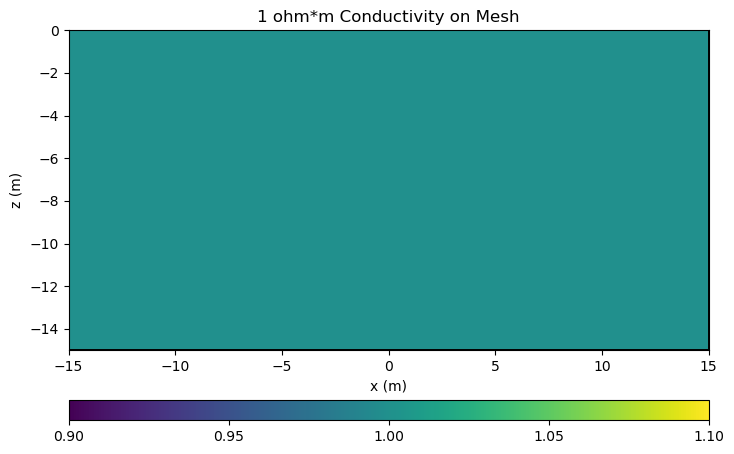

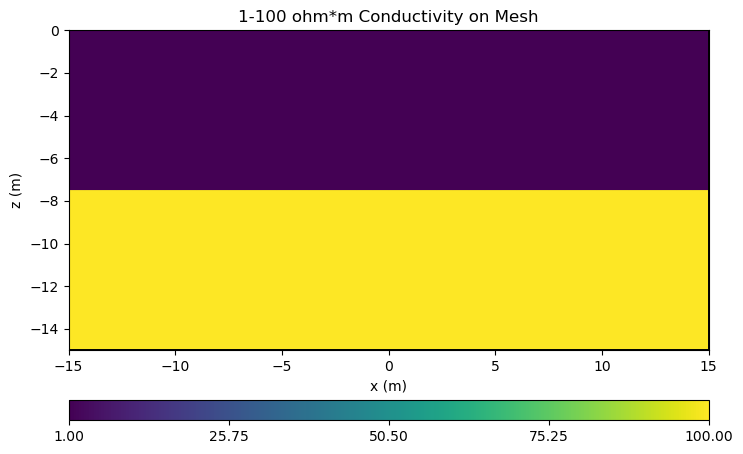

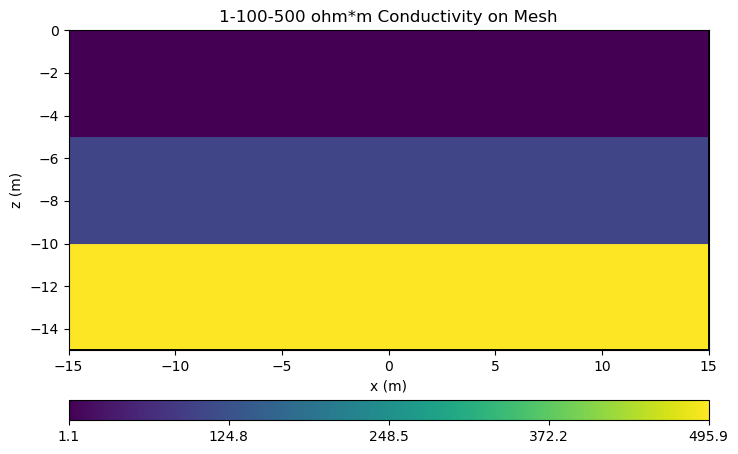

In [74]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

pg.show(mesh, np.zeros(len(mesh.cells())) + sigma, ax=ax)

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("1 ohm*m Conductivity on Mesh")
# original conductivity distribution

sigmas = np.zeros(len(mesh.cells()))
sigmas[0:600]=100
sigmas[600:] = 1


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

pg.show(mesh, sigmas, ax=ax)

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("1-100 ohm*m Conductivity on Mesh")

sigmas2 = np.zeros(len(mesh.cells()))
sigmas2[0:int(len(sigmas2)/3)]=500 + np.random.normal(0,50,1)
sigmas2[int(len(sigmas2)/3):int(2*len(sigmas2)/3)]=100 + np.random.normal(0,10,1)
sigmas2[int(2*len(sigmas2)/3):] = 1 + np.random.normal(0,0.1,1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

pg.show(mesh, sigmas2, ax=ax)

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("1-100-500 ohm*m Conductivity on Mesh")

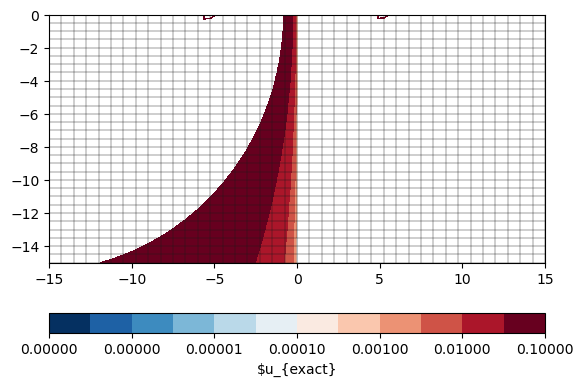

In [67]:
# Analytical Solution
def uAnalytical(p, sourcePos, k, sigma=1):
    """Calculates the analytical solution for the 2.5D geoelectrical problem.

    Solves the 2.5D geoelectrical problem for one wave number k.
    It calculates the normalized (for injection current 1 A and sigma=1 S/m)
    potential at position p for a current injection at position sourcePos.
    Injection at the subsurface is recognized via mirror sources along the
    surface at depth=0.

    Parameters
    ----------
    p : pg.Pos
        Position for the sought potential
    sourcePos : pg.Pos
        Current injection position.
    k : float
        Wave number

    Returns
    -------
    u : float
        Solution u(p)
    """
    r1A = (p - sourcePos).abs()
    # Mirror on surface at depth=0
    r2A = (p - pg.Pos([1.0, -1.0])*sourcePos).abs()

    if r1A > 1e-12 and r2A > 1e-12:
        return  1 / (2.0 * np.pi) * 1/sigma * \
            (pg.math.besselK0(r1A * k) + pg.math.besselK0(r2A * k))
    else:
        return 0.
    
uAna = pg.Vector(list(map(lambda p__: uAnalytical(p__, sourcePosA, k, sigma),
                      mesh.positions())))
uAna -= pg.Vector(list(map(lambda p__: uAnalytical(p__, sourcePosB, k, sigma),
                       mesh.positions())))

ax = pg.show(mesh, data=uAna, cMap="RdBu_r",
          orientation='horizontal', label='$u_{exact}',
          logScale=True, cMin=1e-7, cMax=1e-1,
          contourLines=False,
          nCols=12, nLevs=7,
          showMesh=True)[0]

31/01/23 - 11:01:09 - pyGIMLi - INFO - Fixing pure Neumann boundary condition by forcing: intDomain(u, mesh) = 0
31/01/23 - 11:01:09 - pyGIMLi - WARNING - BlockMatrix add (transpose==True) ... Move me to core


Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.033


31/01/23 - 11:01:09 - pyGIMLi - INFO - Fixing pure Neumann boundary condition by forcing: intDomain(u, mesh) = 0
31/01/23 - 11:01:09 - pyGIMLi - WARNING - BlockMatrix add (transpose==True) ... Move me to core


Solving time:  0.259
Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.034
Solving time:  0.233


Text(0.5, 1.0, 'Two Layer Potential Distribution (1-100-500 ohm*m Conductivity) \n Neumman/Dirichlet BC')

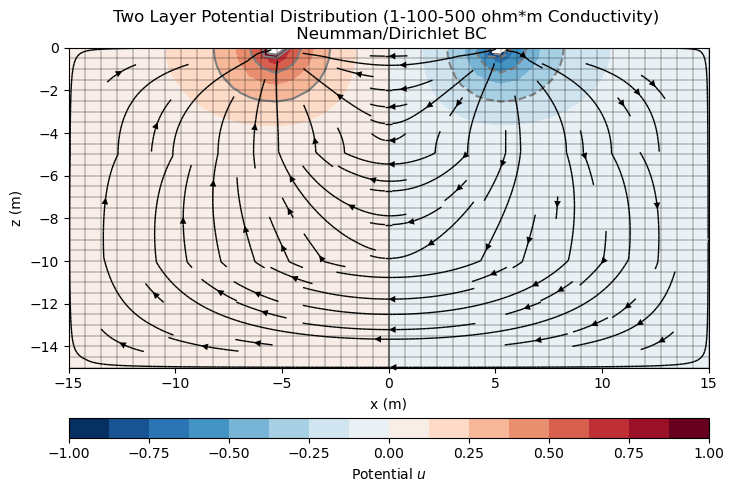

In [75]:
bc=None
u = pg.solve(mesh, a=sigmas2, b=-sigma * k*k,
             rhs=rhsPointSource(mesh, sourcePosA),
             bc=bc, userData={'sourcePos': sourcePosA, 'k': k, 's':1},
             verbose=True)

u -= pg.solve(mesh, a=sigmas2, b=-sigma * k*k,
              rhs=rhsPointSource(mesh, sourcePosB),
              bc=bc, userData={'sourcePos': sourcePosB, 'k': k, 's':1},
              verbose=True)


# The solution is shown by calling

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

axe = pg.show(mesh, data=u, ax=ax, cMap="RdBu_r", cMin=-1, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

# Additionally to the image of the potential we want to see the current flow.
# The current flows along the gradient of our solution and can be plotted as
# stream lines. By default, the drawStreams method draws one segment of a
# stream line per cell of the mesh. This can be a little confusing for dense
# meshes so we can give a second (coarse) mesh as a new cell base to draw the
# streams. If `drawStreams` gets scalar data, the gradients will be calculated.
gridCoarse = pg.createGrid(x=np.linspace(-15.0, 15.0, 20),
                           y=np.linspace(-15.0, 0, 20))
drawStreams(axe, mesh, u, coarseMesh=gridCoarse, color='Black')

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Two Layer Potential Distribution (1-100-500 ohm*m Conductivity) \n Neumman/Dirichlet BC")


Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.03
Solving time:  0.028
Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.041
Solving time:  0.021


Text(0.5, 1.0, 'Two Layer Potential Distribution (1-100 ohm*m Conductivity) \n Robin BC')

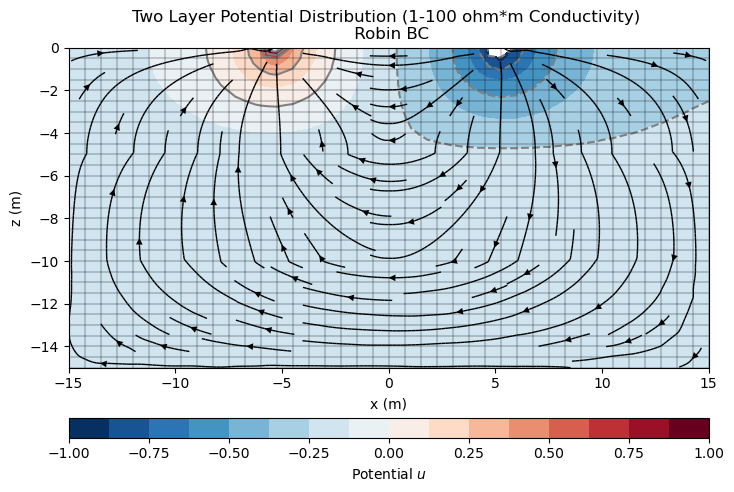

In [76]:
bc={'Robin': {'1,2,3': RobinBC}}
u2 = pg.solve(mesh, a=sigmas2, b=-sigma * k*k,
             rhs=rhsPointSource(mesh, sourcePosA),
             bc=bc, userData={'sourcePos': sourcePosA, 'k': k, 's':1},
             verbose=True)

u2 -= pg.solve(mesh, a=sigmas2, b=-sigma * k*k,
              rhs=rhsPointSource(mesh, sourcePosB),
              bc=bc, userData={'sourcePos': sourcePosB, 'k': k, 's':1},
              verbose=True)


# The solution is shown by calling

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

axe = pg.show(mesh, data=u2, ax=ax, cMap="RdBu_r", cMin=-1, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

# Additionally to the image of the potential we want to see the current flow.
# The current flows along the gradient of our solution and can be plotted as
# stream lines. By default, the drawStreams method draws one segment of a
# stream line per cell of the mesh. This can be a little confusing for dense
# meshes so we can give a second (coarse) mesh as a new cell base to draw the
# streams. If `drawStreams` gets scalar data, the gradients will be calculated.
gridCoarse = pg.createGrid(x=np.linspace(-15.0, 15.0, 20),
                           y=np.linspace(-15.0, 0, 20))
drawStreams(axe, mesh, u2, coarseMesh=gridCoarse, color='Black')

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Two Layer Potential Distribution (1-100 ohm*m Conductivity) \n Robin BC")



Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.029
Solving time:  0.027
Mesh:  Mesh: Nodes: 3741 Cells: 1200 Boundaries: 2470
Assembling time:  0.038
Solving time:  0.025000000000000022


Text(0.5, 1.0, 'Two Layer Potential Distribution (1-100 ohm*m Conductivity) \n Mixed BC')

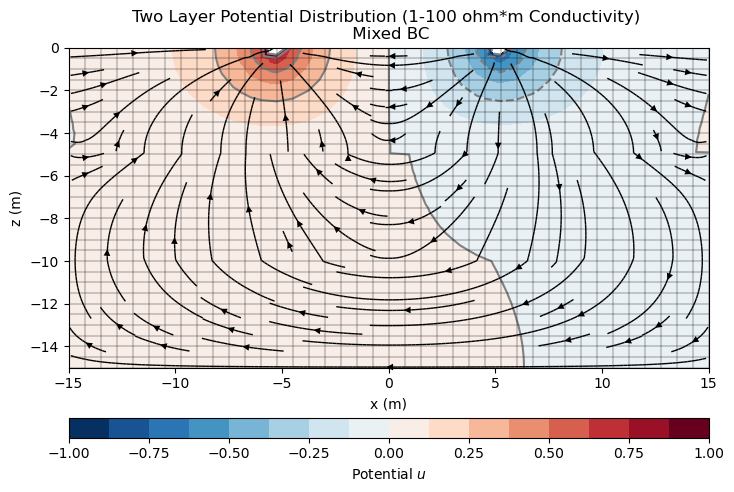

In [77]:
bc={'Robin': {'1,2,3': mixedBC}}
u3 = pg.solve(mesh, a=sigmas2, b=-sigma * k*k,
             rhs=rhsPointSource(mesh, sourcePosA),
             bc=bc, userData={'sourcePos': sourcePosA, 'k': k, 's':1},
             verbose=True)

u3 -= pg.solve(mesh, a=sigmas2, b=-sigma * k*k,
              rhs=rhsPointSource(mesh, sourcePosB),
              bc=bc, userData={'sourcePos': sourcePosB, 'k': k, 's':1},
              verbose=True)


# The solution is shown by calling

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

axe = pg.show(mesh, data=u3, ax=ax, cMap="RdBu_r", cMin=-1, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

# Additionally to the image of the potential we want to see the current flow.
# The current flows along the gradient of our solution and can be plotted as
# stream lines. By default, the drawStreams method draws one segment of a
# stream line per cell of the mesh. This can be a little confusing for dense
# meshes so we can give a second (coarse) mesh as a new cell base to draw the
# streams. If `drawStreams` gets scalar data, the gradients will be calculated.
gridCoarse = pg.createGrid(x=np.linspace(-15.0, 15.0, 20),
                           y=np.linspace(-15.0, 0, 20))
drawStreams(axe, mesh, u3, coarseMesh=gridCoarse, color='Black')

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Two Layer Potential Distribution (1-100 ohm*m Conductivity) \n Mixed BC")



Text(0.5, 1.0, 'Difference Between Robin & Mixed Solutions (2-Layer, 1-100 ohm*m)')

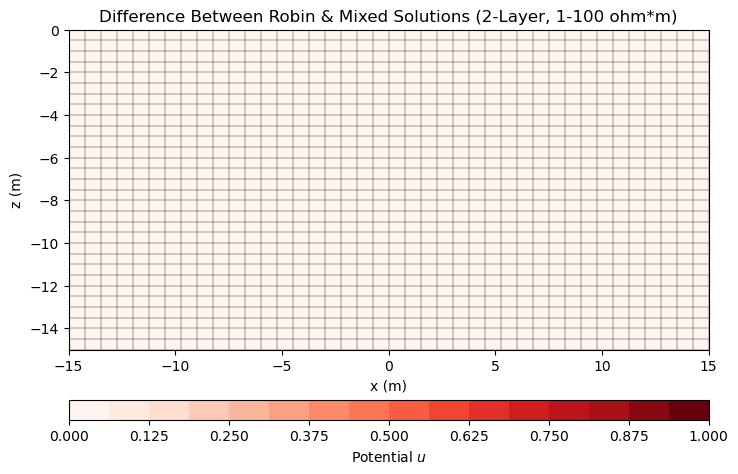

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
axe = pg.show(mesh, data=np.abs(u3-u2), ax=ax, cMap="Reds", cMin=0, cMax=1,
             orientation='horizontal', label='Potential $u$',
             nCols=16, nLevs=9, showMesh=True)[0]

ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Difference Between Robin & Mixed Solutions (2-Layer, 1-100 ohm*m)")